# Secular Origin

In [1]:
import rebound
import airball
import airball.units as u
import numpy as np
import math
import pal
import corner


import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("figures/paper.mplstyle")

pt = 1.0 / 72.27
col_width = 245.26653 * pt
txt_width = 513.11743 * pt

pi = np.pi
twopi = 2.0 * np.pi

## Data

In [2]:
# Load some stored outer Solar System data for general reference.
ss = rebound.Simulation()
ss.add("outer solar system")
ss.remove(index=5)  # remove Pluto
ss.move_to_com()

ss_outer = pal.secular.Results("data/solar_system_20Myr.sec")

In [3]:
# Load the FFT data for the Solar System and the Flyby systems.
ssdat = pal.unpkl("data/solar_system_secular_modes.secs")
results = pal.unpkl("data/flyby_secular_modes.secs")

In [4]:
# Load the stellar data, sampled from an Open Cluster (oc) environment using a Chabrier (2003) IMF.
N = int(5e4)
oc = airball.StellarEnvironment("data/oc.se")
oc.density = oc.units.mass * oc.density / oc.mean_mass
stars = airball.Stars("data/flyby.stars")
stars.units.angle = u.deg

In [5]:
oc.stats()

Open Cluster
------------------------------------------
Stellar Density:            315.7 stars / pc3 
Velocity Scale:                 1 km / s 
Mass Range:             0.001 - 100 solMass
Median Mass:              0.07927 solMass 
Mean Mass:                 0.3168 solMass 
Max Impact Param:              75 AU 
Encounter Rate:         0.0003177 stars / Myr 
------------------------------------------


## Initial Mass Functions (IMFs)

Compare different IMFs. Specifically, the Kroupa (2001), Chabrier (2003), Chabrier (2005), Maschberger (2013), and Kirkpatrick et al. (2024) IMFs.

In [6]:
def maschberger_mf(m):
    alpha = 2.3
    beta = 1.4
    mu = 0.2
    return ((m / mu) ** -alpha) / (1.0 + (m / mu) ** (1.0 - alpha)) ** beta


maschberger_imf = airball.IMF(1e-3, 1e2, mass_function=maschberger_mf)

In [7]:
def kirkpatrick_mf(m):
    return np.where(
        m < 0.05,
        0.0469 * m**-0.6,
        np.where(
            m < 0.22,
            0.134 * m**-0.25,
            np.where(m < 0.55, 0.0273 * m**-1.3, 0.0150 * m**-2.3),
        ),
    )


kirkpatrick_imf = airball.IMF(1e-3, 1e2, kirkpatrick_mf)

In [8]:
def kroupa_mf(m):
    return np.where(
        m < 0.08,
        m**-0.3,
        np.where(
            m < 0.5,
            0.08**-0.3 * (m / 0.08) ** -1.3,
            0.08**-0.3 * (0.5 / 0.08) ** -1.3 * (m / 0.5) ** -2.3,
        ),
    )


kroupa_imf = airball.IMF(1e-3, 1e2, mass_function=kroupa_mf)

In [9]:
def c05_mf(x, x_0=1):
    c05 = airball.imf.chabrier_2005_single()
    salpeter55 = airball.imf.salpeter_1955(A=c05(1))
    return np.where(x < x_0, c05(x), salpeter55(x))


chabrier05_imf = airball.IMF(1e-3, 1e2, mass_function=c05_mf)

In [10]:
x = oc.IMF.masses(1e5)


def div(pdf):
    """Normalize all the IMFs to the same value at x = 100 solMass."""
    return oc.IMF.pdf(x[-1]) / pdf(x[-1])

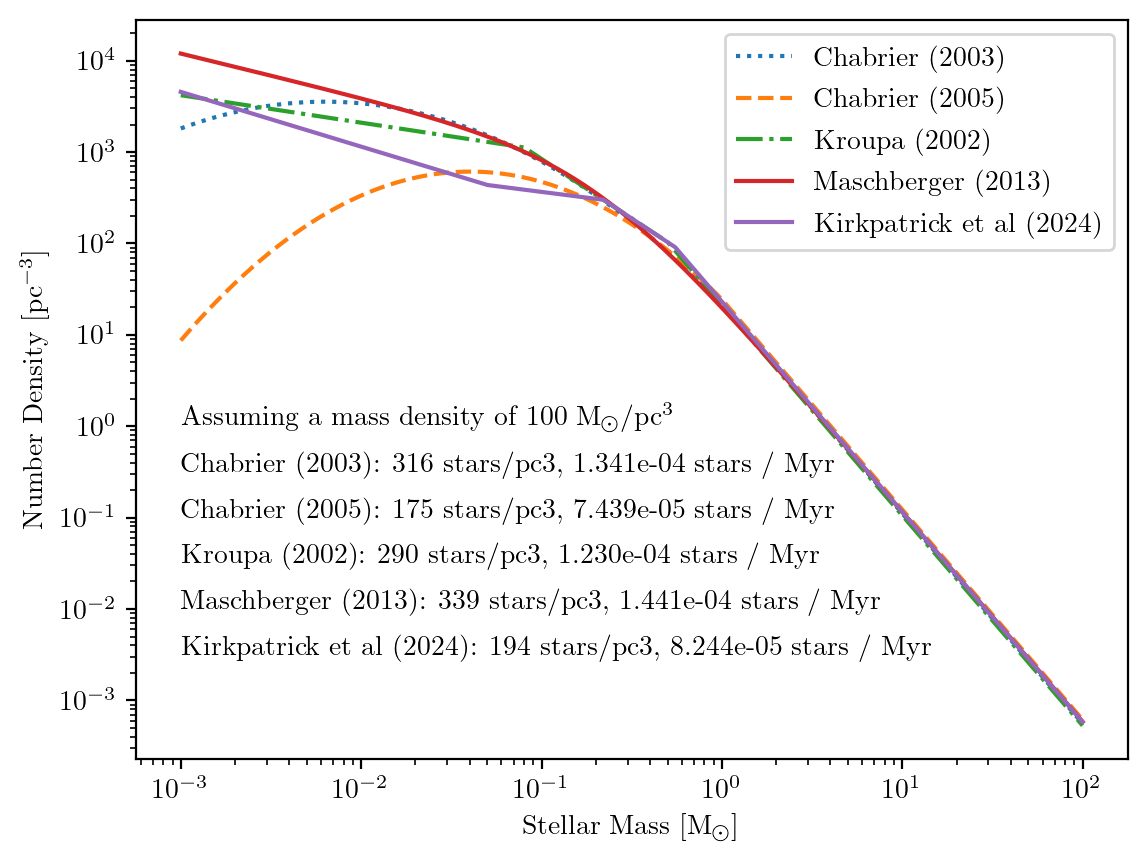

In [11]:
imf_label = [
    "Chabrier (2003)",
    "Chabrier (2005)",
    "Kroupa (2002)",
    "Maschberger (2013)",
    "Kirkpatrick et al (2024)",
]
ls = [":", "--", "-.", "-", "-"]
pdfs = [
    oc.IMF.pdf,
    chabrier05_imf.pdf,
    kroupa_imf.pdf,
    maschberger_imf.pdf,
    kirkpatrick_imf.pdf,
]
x = oc.IMF.masses(1e4)
fac = map(div, pdfs)
plt.text(
    1e-3,
    10 ** (0),
    r"Assuming a mass density of 100 M$_\odot$/pc$^{3}$",
    rasterized=False,
)
for i, f in enumerate(pdfs):
    kp = np.trapezoid(f(x), x)
    kpm = np.trapezoid(f(x) * x, x)
    num = 100 * kp / kpm
    b = (75 * u.au).to(u.pc)
    sigma = np.pi * b * b
    n = num * (oc.units.object) * (u.pc) ** -3
    v = (1 * u.km / u.s).to(u.pc / u.Myr)
    gamma = n * sigma * v
    s = imf_label[i].rjust(25)
    xloc, yloc = 1e-3, 10 ** (-i / 2 - 0.5)
    plt.text(xloc, yloc, f"{s}: {num:.0f} stars/pc3, {gamma:.3e}", rasterized=False)
    plt.loglog(x, f(x) * num, ls[i], label=imf_label[i])
plt.legend(loc=1)
plt.xlabel(r"Stellar Mass [M$_\odot$]")
plt.ylabel(r"Number Density [pc$^{-3}$]")
plt.savefig("figures/IMFs.pdf", bbox_inches="tight")
plt.show()

### Flyby chances

In [12]:
def P(k, t, r=oc.encounter_rate.value / u.Myr):
    """Chance of *exactly* k flybys, per million years."""
    return (((r * t) ** k * np.exp(-r * t)) / math.factorial(k)).value


def Pup(k, t):
    """Chance of at least k flybys, per million years."""
    tot = 0
    for i in range(k):
        tot += P(i, t)
    return 1 - tot

In [13]:
print("Chance of exactly N flybys")
for i in range(5):
    print(f"{i} : {100 * P(i, 100 * u.Myr):12.8f}%")

Chance of exactly N flybys
0 :  96.87266606%
1 :   3.07791496%
2 :   0.04889697%
3 :   0.00051786%
4 :   0.00000411%


In [14]:
print("Chance of at least N flybys")
for i in range(5):
    print(f"{i} : {100 * Pup(i, 100 * u.Myr):12.8f}%")

Chance of at least N flybys
0 : 100.00000000%
1 :   3.12733394%
2 :   0.04941898%
3 :   0.00052200%
4 :   0.00000414%


In [15]:
Pup(1, 100 * u.Myr)

np.float64(0.03127333942328292)

In [16]:
# Using the number densities, compare the expected stellar flyby rates.
gammas = []
for f in pdfs:
    num_density = np.trapezoid(f(x), x)
    mass_density = np.trapezoid(f(x) * x, x)
    num = 100 * num_density / mass_density
    b = (75 * u.au).to(u.pc)
    sigma = np.pi * b * b
    n = num * (oc.units.object) * (u.pc) ** -3
    # v = (1 * u.km/u.s).to(u.pc/u.Myr)
    v = oc.velocity_mean.to(u.pc / u.Myr)
    gamma = n * sigma * v
    gammas.append(gamma.value)
    print(f"{num:.0f}, {gamma:.4e}")

316, 3.1773e-04 stars / Myr
175, 1.7627e-04 stars / Myr
290, 2.9144e-04 stars / Myr
339, 3.4143e-04 stars / Myr
194, 1.9535e-04 stars / Myr


In [17]:
# Fractional encounter rate compared to Chabrier (2003).
np.array(gammas) / oc.encounter_rate.value

array([1.00000002, 0.55476893, 0.91724746, 1.07459792, 0.61482729])

In [18]:
# Brown Dwarf Fraction (bdf)
x_bd = x[x <= 0.08]
bdf = []
for f in pdfs:
    kpbd = np.trapezoid(f(x_bd), x_bd)
    kp = np.trapezoid(f(x), x)
    kpm = np.trapezoid(f(x) * x, x)
    num_bd = 100 * kpbd / kpm
    num = 100 * kp / kpm
    b = (75 * u.au).to(u.pc)
    sigma = np.pi * b * b
    n = num * (oc.units.object) * (u.pc) ** -3
    v = oc.velocity_mean.to(u.pc / u.Myr)
    gamma = n * sigma * v
    bdf.append(num_bd / num)
    print(f"{num:4.0f}, {num_bd:4.0f}: {num_bd / num:6.3f}, {gamma:.4e}")
bdf = np.asarray(bdf)

 316,  158:  0.502, 3.1773e-04 stars / Myr
 175,   41:  0.233, 1.7627e-04 stars / Myr
 290,  123:  0.423, 2.9144e-04 stars / Myr
 339,  179:  0.528, 3.4143e-04 stars / Myr
 194,   55:  0.285, 1.9535e-04 stars / Myr


In [19]:
# Normalized Brown Dwarf Fraction, compared to Chabrier (2003).
nbdf = bdf / bdf[0]
nbdf

array([1.        , 0.46419405, 0.84315826, 1.05222788, 0.56816058])

In [20]:
# Substellar Flyby Likelihood over 100 Myrs.
deltaT = 100 * u.Myr
fbrt = deltaT * oc.encounter_rate
gms = np.array(gammas) / oc.encounter_rate.value
for i in range(len(gms)):
    print(f"1 in {1 / (fbrt.value * gms[i] * (422 / stars.N) * nbdf[i]):,.0f}")

1 in 3,729
1 in 14,481
1 in 4,822
1 in 3,298
1 in 10,675


In [21]:
# Substellar Flyby Likelihood over 10 Myrs.
deltaT = 10 * u.Myr
fbrt = deltaT * oc.encounter_rate
gms = np.array(gammas) / oc.encounter_rate.value
for i in range(len(gms)):
    print(f"1 in {1 / (fbrt.value * gms[i] * (422 / stars.N) * nbdf[i]):,.0f}")

1 in 37,291
1 in 144,807
1 in 48,218
1 in 32,980
1 in 106,752


## Results

In [22]:
g = 0
good = []
for i, r in enumerate(results):
    if r.good:
        g += 1
        good.append(i)
    r.star = stars[i]
good = np.asarray(good)
print(
    f"{100 * (len(results) - g) / len(results):1.2f}% of flybys result in an ejected planet."
)

58.67% of flybys result in an ejected planet.


In [23]:
try:
    solar_system_metric = np.load("data/solar_system_metric.npy")
except FileNotFoundError:
    solar_system_metric = []
    for s0 in np.random.choice(ssdat, size=2500, replace=False):
        solar_system_metric.append(pal.solar_subset(s0, ssdat))
    solar_system_metric = np.asarray(pal.solar_system_metric).flatten()
    np.save("data/solar_system_metric.npy", solar_system_metric)

In [24]:
try:
    flyby_metric = np.load("data/flyby_metric.npy")
except FileNotFoundError:
    for i in good[len(good) // 2 :]:
        flyby_metric[i] = pal.solar(results[i], ssdat)
    np.save("data/flyby_metric.npy", flyby_metric)

In [25]:
mn = np.min(flyby_metric, axis=1)
md = np.median(flyby_metric, axis=1)
mx = np.max(flyby_metric, axis=1)

for i in range(len(results)):
    results[i].M = mn[i], md[i], mx[i]

In [26]:
solar_system_metric.max()

np.float64(0.43368666513300236)

In [27]:
matches = np.any(flyby_metric < solar_system_metric.max(), axis=1)
inds = np.arange(N)[matches]
inds = inds[
    np.argsort(np.sum(flyby_metric[inds] < solar_system_metric.max(), axis=1))[::-1]
]
print(
    f"The number of flyby systems that have a metric value less than the maximum metric value of the solar system: {np.sum(matches)}"
)
print(
    f"The number of flyby systems whose median metric value is less than the maximum metric value of the solar system: {np.sum(np.median(flyby_metric, axis=1) < solar_system_metric.max())}"
)
print(
    f"\nThe flyby system with the most metric values less than the solar system max, index:{inds[0]}, with {100 * np.sum(flyby_metric[inds[0]] < solar_system_metric.max()) / len(ssdat)}% below the max."
)
print(
    f"\nThere are {len(inds)} simulations that overlap with the solar system. 1:{np.divide(len(results), len(inds)):1.0f} chance."
)

The number of flyby systems that have a metric value less than the maximum metric value of the solar system: 422
The number of flyby systems whose median metric value is less than the maximum metric value of the solar system: 92

The flyby system with the most metric values less than the solar system max, index:19399, with 100.0% below the max.

There are 422 simulations that overlap with the solar system. 1:118 chance.


In [28]:
likelihood = ((len(inds) / stars.N) * (10 * u.Myr * oc.encounter_rate)).value
likelihood, 1 / likelihood

(2.6816235530326845e-05, 37290.84191810168)

## Figures

### Corner Plots

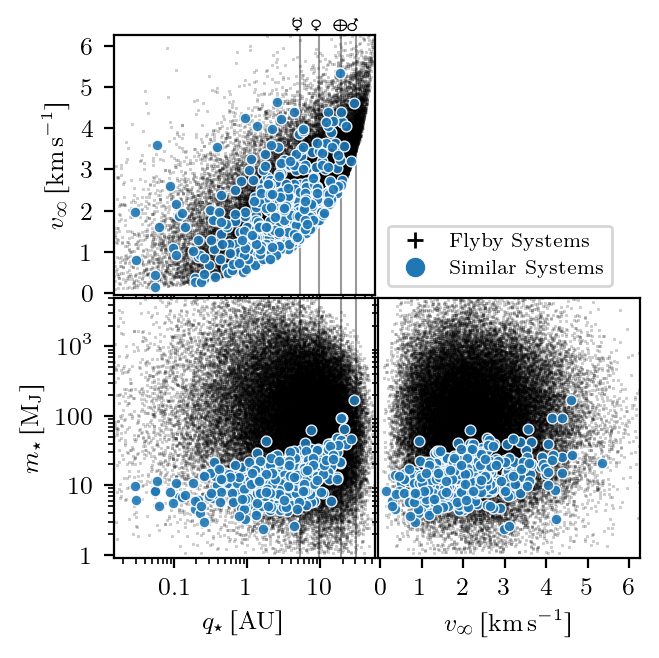

In [29]:
plt.rcParams.update({"font.size": 9})

fig, ax = plt.subplots(2, 2, figsize=(col_width, col_width))

for ak in [ax[0, 0], ax[1, 0]]:
    for i, p in enumerate(ss.particles[1:]):
        ak.axvline(p.a, c="k", ls="-", lw=0.75, alpha=0.4, zorder=0)
        ak.set_xscale("log")

ax[0, 0].plot(
    stars.q(ss).value, stars.v, "k+", zorder=0, ms=1, alpha=0.2, rasterized=True
)
ax[1, 0].plot(
    stars.q(ss).value,
    stars.m.to(u.jupiterMass),
    "k+",
    zorder=0,
    ms=1,
    alpha=0.2,
    rasterized=True,
)
ax[1, 1].plot(
    stars.v, stars.m.to(u.jupiterMass), "k+", zorder=0, ms=1, alpha=0.2, rasterized=True
)

sc = ax[0, 0].scatter(
    stars[inds].q(ss).value,
    stars[inds].v,
    color="C0",
    edgecolors="w",
    lw=0.5,
    s=15,
    alpha=0.9,
)
ax[1, 0].scatter(
    stars[inds].q(ss).value,
    stars[inds].m.to(u.jupiterMass),
    color="C0",
    edgecolors="w",
    lw=0.5,
    s=15,
    alpha=0.9,
)
ax[1, 1].scatter(
    stars[inds].v,
    stars[inds].m.to(u.jupiterMass),
    color="C0",
    edgecolors="w",
    lw=0.5,
    s=15,
    alpha=0.9,
)

ax[0, 0].set_ylabel(r"$v_\infty\,[\mathrm{km\,s^{-1}}]$")
ax[1, 1].set_xlabel(r"$v_\infty\,[\mathrm{km\,s^{-1}}]$")
ax[1, 0].set_xlabel(r"$q_\star\,[\mathrm{AU}]$")
ax[1, 0].set_ylabel(r"$m_\star\,[\mathrm{M_J}]$")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")
ax[1, 1].set_yscale("log")
for label in ax[1, 1].yaxis.get_ticklabels():
    label.set_visible(False)

ticks = np.linspace(0, 7, 8)
ax[0, 0].set_yticks(ticks)
ax[1, 1].set_xticks(ticks)
vals = []
for i in [1, 10, 100, 1000]:
    for j in range(9):
        vals.append(i + j * i)
ax[1, 0].set_yticks(vals, [""] * len(vals), minor=True)
ax[1, 0].set_yticks(np.geomspace(1, 1e3, 4), [r"$1$", r"$10$", r"$100$", r"$10^{3}$"])
vals = []
for i in [0.01, 0.1, 1, 10]:
    for j in range(9):
        vals.append(i + j * i)
vals.append(100)
ax[1, 0].set_xticks(vals, [""] * len(vals), minor=True)
ax[1, 0].set_xticks(np.geomspace(0.01, 10, 4), [r"$0.01$", r"$0.1$", r"$1$", r"$10$"])
ax[1, 1].set_yticks([], [])

ax[0, 1].set_yticks([], [])
ax[0, 1].set_xticks([], [])
for loc, spine in ax[0, 1].spines.items():
    spine.set_visible(False)
ax[0, 1].set_xlim(0, 1)
ax[0, 1].set_ylim(0, 1)
ax[0, 1].plot(-1, -1, "k+", label="Flyby Systems")
ax[0, 1].plot(-1, -1, "C0o", label="Similar Systems")
ax[0, 1].legend(loc=3, prop={"size": 7})

ax[0, 0].set_ylim(-0.05, 6.25)  # Velocity Range
ax[1, 1].set_xlim(-0.05, 6.25)  # Velocity Range
ax[0, 0].set_xlim(1.5e-2, 56)  # Perihelion Range
ax[1, 0].set_xlim(1.5e-2, 56)  # Perihelion Range
ax[1, 0].set_ylim(0.9, 5e3)  # Mass Range
ax[1, 1].set_ylim(0.9, 5e3)  # Mass Range

symbols = [
    r"$\Mercury$",
    r"$\Venus$",
    r"$\Earth$",
    r"$\Mars$",
    r"$\Jupiter$",
    r"$\Saturn$",
    r"$\Uranus$",
    r"$\Neptune$",
]
for i, p in enumerate(ss.particles[1:]):
    ax[0, 0].text(p.a * 0.775, 6.35, symbols[i], size=6)

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("figures/flyby-params-oja.pdf", bbox_inches="tight")
plt.show()

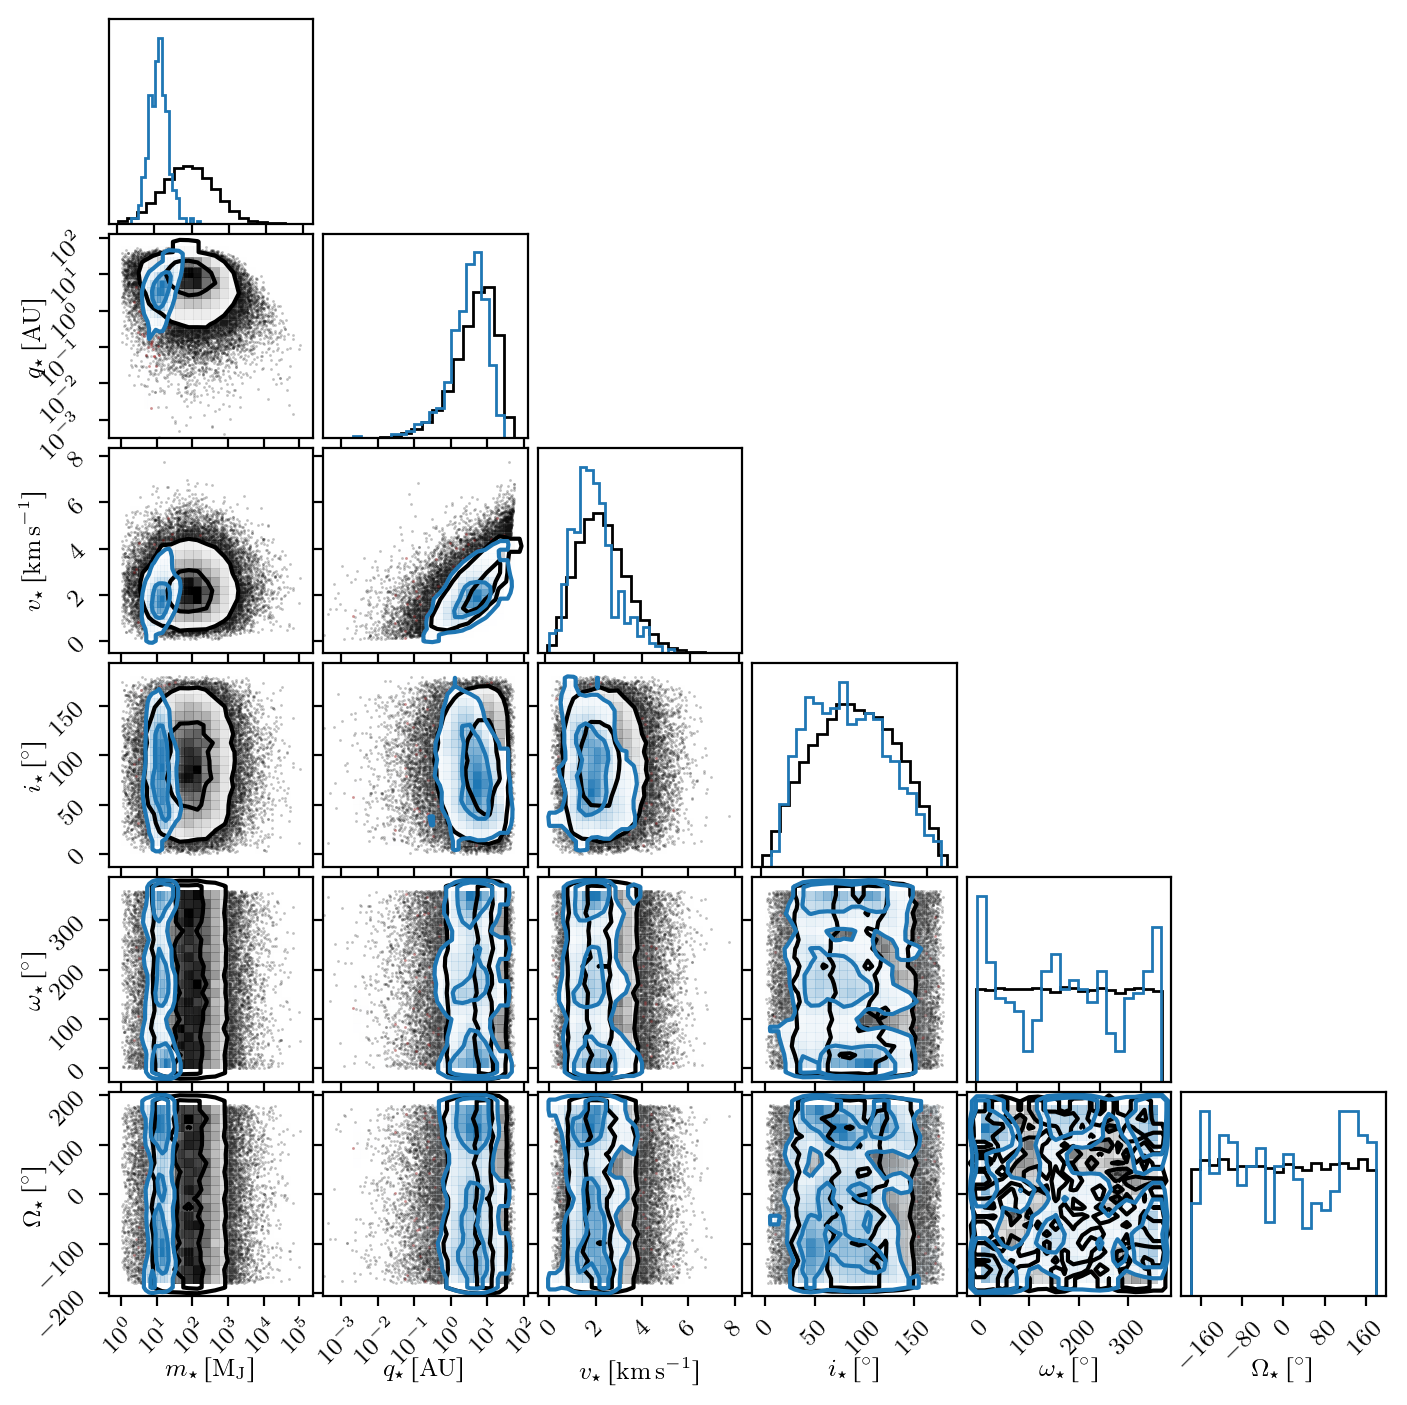

In [30]:
labels = [
    r"$m_\star\,[\mathrm{M}_\mathrm{J}]$",
    r"$q_\star\,[\mathrm{AU}]$",
    r"$v_\star\,[\mathrm{km\,s}^{-1}]$",
    r"$i_\star\,[{}^\circ]$",
    r"$\omega_\star\,[{}^\circ]$",
    r"$\Omega_\star\,[{}^\circ]$",
]
# rm = np.logical_not(np.isinf(l0))
dat = np.asarray(
    [
        np.log10(stars.m.to(u.jupiterMass).value),
        np.log10(stars.q(ss).value),
        stars.v.value,
        stars.inc.value,
        stars.omega.value,
        stars.Omega.value,
    ]
)
# gdat = dat[:,rm]

plt.rcParams.update({"font.size": 9})
fig, ax = plt.subplots(len(labels), len(labels), figsize=(txt_width, txt_width))
corner.corner(
    dat.T,
    labels=labels,
    hist_kwargs={"density": True},
    smooth=False,
    fig=fig,
    axs=ax,
    plot_contours=True,
    plot_density=True,
    data_kwargs={"ms": 1, "alpha": 0.25, "color": "k"},
    levels=(1 - np.exp(-0.5 * np.arange(1, 3, 1) ** 2)),
)
corner.corner(
    dat.T[inds],
    labels=labels,
    hist_kwargs={"density": True, "color": "C0"},
    color="C0",
    smooth=True,
    fig=fig,
    axs=ax,
    plot_contours=True,
    plot_density=True,
    data_kwargs={"ms": 1, "alpha": 0.25, "color": "r"},
    levels=(1 - np.exp(-0.5 * np.arange(1, 3, 1) ** 2)),
)

for i in range(len(labels)):
    ax[i, 0].set_xticks(
        np.linspace(0, 5, 6), [rf"$10^{{{i}}}$" for i in range(6)] if i == 5 else []
    )
    ax[i, 1].set_xticks(
        np.linspace(-3, 2, 6) if i > 0 else [],
        [rf"$10^{{{i:1.0f}}}$" for i in np.linspace(-3, 2, 6)] if i == 5 else [],
    )
    ax[i, 1].set_xlim(-3.5, 2.1)
ax[1, 0].set_yticks(
    np.linspace(-3, 2, 6), [rf"$10^{{{i:1.0f}}}$" for i in np.linspace(-3, 2, 6)]
)
ax[1, 0].set_ylim(-3.5, 2.1)

# plt.savefig('figures/corner-oja.pdf')
plt.show()

### Log Spectral Distance Comparison

In [31]:
# Outer Solar System data for plotting function (takes about one minute to initialize).
zfft = np.zeros((2, len(ssdat), 8, 2048))
for j, fft in enumerate(["zfft", "ζfft"]):
    for i, s in enumerate(ssdat):
        zfft[j, i] = np.abs(getattr(s, fft).copy())

s1 = (100 - 68.27) / 2
s2 = (100 - 95.45) / 2
s3 = (100 - 99.73) / 2
percentiles = [s3, s2, s1, 50, 100 - s1, 100 - s2, 100 - s3]

pp = []
for i in range(2):
    pp.append(np.percentile(zfft[i], percentiles, axis=0))
pp = np.asarray(pp)

In [32]:
def fftplot(
    sec, pp, savename=None, modesOnly=False, size=(txt_width, txt_width * 0.66), fontSize=9, bw=False
):
    """Plot the frequency decomposition of a secular system compared against the secular variation of the Solar System data."""
    if not modesOnly:
        plt.rcParams.update({"font.size": fontSize})
        fig, ax = plt.subplots(sec.n, 2, figsize=size, sharex=True, sharey=True)
    for ff, f in enumerate(["g", "s"]):
        amp = "A" if f == "g" else "B"
        fft = "zfft" if f == "g" else "ζfft"
        if ff == 0:
            print(
                f"{sec.index}, M: {f'{sec.M:8.5f}' if type(sec.M) is not type((0, 0)) else '(' + ', '.join([f'{m:8.5f}' for m in sec.M]) + ')'}"
            )
            if sec.star is not None:
                if sec.star.m < 0.1 * u.solMass:
                    sec.star.units.mass = u.jupiterMass
                print(sec.star)
                print("q:", sec.star.q(ss))
                print("ss", ", ".join([f"{a:8.4f}" for a in ss_outer.a]))
                print("->", ", ".join([f"{a:8.4f}" for a in sec.a]))
                print()
        print("ss", ", ".join([f"{a.value:8.4f}" for a in getattr(ss_outer, f)]))
        print("->", ", ".join([f"{a.value:8.4f}" for a in getattr(sec, f)]))
        print(
            "ss", ", ".join([f"{a * 1e3:8.6f}" for a in np.abs(getattr(ss_outer, amp))])
        )
        print("->", ", ".join([f"{a * 1e3:8.6f}" for a in np.abs(getattr(sec, amp))]))
        print()

        if not modesOnly:
            p = pp[ff]
            ecs = [
                r"$\left|\mathcal{F}[z_1]\right|$",
                r"$\left|\mathcal{F}[z_2]\right|$",
                r"$\left|\mathcal{F}[z_3]\right|$",
                r"$\left|\mathcal{F}[z_4]\right|$",
                r"$\left|\mathcal{F}[z_5]\right|$",
                r"$\left|\mathcal{F}[z_6]\right|$",
                r"$\left|\mathcal{F}[z_7]\right|$",
                r"$\left|\mathcal{F}[z_8]\right|$",
            ]
            incs = [
                r"$\left|\mathcal{F}[\zeta_1]\right|$",
                r"$\left|\mathcal{F}[\zeta_2]\right|$",
                r"$\left|\mathcal{F}[\zeta_3]\right|$",
                r"$\left|\mathcal{F}[\zeta_4]\right|$",
                r"$\left|\mathcal{F}[\zeta_5]\right|$",
                r"$\left|\mathcal{F}[\zeta_6]\right|$",
                r"$\left|\mathcal{F}[\zeta_7]\right|$",
                r"$\left|\mathcal{F}[\zeta_8]\right|$",
            ]

            i = np.argsort(sec.freqs)
            j = np.argsort(sec.freqs)
            for k in range(sec.n):
                ax[k, ff].grid(True, which="major", alpha=0.3)
                # ax[k,ff].set_title(f'{names[k]}', y=0.86, x=0.125, size=17)
                ax[k, ff].set_xlabel(
                    r"$\mathrm{Frequency},\,\nu\,\mathrm{[arcsec\,yr^{-1}]}$",
                    fontsize=fontSize,
                )
                if ff == 1:
                    ay = ax[k, ff].twinx()
                    ay.set_ylabel(
                        f"{ecs[(k + sec.n) % 8] if f == 'g' else incs[(k + sec.n) % 8]}",
                        rotation=270,
                        fontsize=fontSize,
                    )
                    ay.yaxis.set_label_coords(
                        1 + (0.275 * np.sqrt(fontSize) / np.sqrt(18)), 0.5
                    )
                    for label in ay.get_yticklabels():
                        label.set_visible(False)
                    ay.set_yticks([])
                    ax[k, ff].tick_params(labelright=True, right=True, left=False)
                else:
                    ax[k, ff].set_ylabel(
                        f"{ecs[(k + sec.n) % 8] if f == 'g' else incs[(k + sec.n) % 8]}",
                        fontsize=fontSize,
                    )
                ax[k, ff].plot(
                    sec.freqs[j],
                    np.abs(getattr(sec, fft)[k, j]) / sec.N,
                    "k--" if bw else "k-",
                    alpha=1,
                    label=r"$\mathrm{Flyby\;System}$",
                )
                ax[k, ff].plot(
                    sec.freqs[i],
                    p[3, (k + sec.n) % 8, i] / sec.N,
                    "k" if bw else f"C{(k + 4 + sec.n) % 8}",
                    alpha=0.8 / (2 if bw else 1),
                )
                ax[k, ff].fill_between(
                    sec.freqs[i],
                    p[2, (k + sec.n) % 8, i] / sec.N,
                    p[-3, (k + sec.n) % 8, i] / sec.N,
                    color="k" if bw else f"C{(k + 4 + sec.n) % 8}",
                    alpha=0.5 / (2 if bw else 1),
                    label=r"$\mathrm{Solar\;System}$",
                )  # , label=r'SS $1\sigma$')
                ax[k, ff].fill_between(
                    sec.freqs[i],
                    p[1, (k + sec.n) % 8, i] / sec.N,
                    p[-2, (k + sec.n) % 8, i] / sec.N,
                    color="k" if bw else f"C{(k + 4 + sec.n) % 8}",
                    alpha=0.25 / (2 if bw else 1),
                )  # , label=r'SS $2\sigma$')
                ax[k, ff].fill_between(
                    sec.freqs[i],
                    p[0, (k + sec.n) % 8, i] / sec.N,
                    p[-1, (k + sec.n) % 8, i] / sec.N,
                    color="k" if bw else f"C{(k + 4 + sec.n) % 8}",
                    alpha=0.125 / (2 if bw else 1),
                )  # , label=r'SS $3\sigma$')
                ax[k, ff].plot(
                    sec.freqs[j],
                    np.abs(getattr(sec, fft)[k, j]) / sec.N,
                    "k-",
                    alpha=0.1,
                )
    if not modesOnly:
        ax[-1, 1].legend(prop={"size": fontSize - 2})
        ax[0, 0].set_yscale("log")

        ax[0, 0].set_xticks(
            np.linspace(-60, 60, 13),
            [
                r"$-60$",
                r"",
                r"$-40$",
                r"",
                r"$-20$",
                r"",
                r"$0$",
                r"",
                r"$20$",
                r"",
                r"$40$",
                r"",
                r"$60$",
            ],
        )
        ax[0, 0].set_xticks(np.linspace(-60, 60, 25), minor=True)
        ax[0, 0].set_yticks(
            np.logspace(-8, -1, 8),
            ["", "", r"$10^{-6}$", "", r"$10^{-4}$", "", r"$10^{-2}$", ""],
        )

        ax[0, 0].set_xlim(np.asarray([-66, 66]))
        ax[0, 0].set_ylim(2e-8, 0.11)

        plt.subplots_adjust(hspace=0.01, wspace=0.015)
        if savename is not None:
            plt.savefig(savename, bbox_inches="tight")
        plt.show()

19399, M: ( 0.29662,  0.33643,  0.42924)
<airball.stars.Star object at 0x12f5d6b10, m= 8.274 jupiterMass, b= 20.54 AU, v= 2.69 km / s, inc= 131.2 deg, omega= 208.5 deg, Omega= -140.1 deg>
q: 1.6927802855817236 AU
ss   5.2025,   9.5460,  19.1945,  30.0704
->   5.3362,   9.5439,  18.5822,  30.8525

ss   4.2575,  28.2458,   3.0880,   0.6730
->   4.4443,  25.6184,   3.0839,   0.5640
ss 44.172792, 48.205320, 29.027593, 9.137972
-> 28.759165, 7.908059, 54.305175, 35.109907

ss  -0.6917, -26.3483,  -2.9926,  -0.6918
->  -0.6058, -28.1176,  -3.3073,  -0.6058
ss 0.577392, 7.848114, 8.869732, 5.811626
-> 0.114456, 3.497916, 8.023470, 1.202735



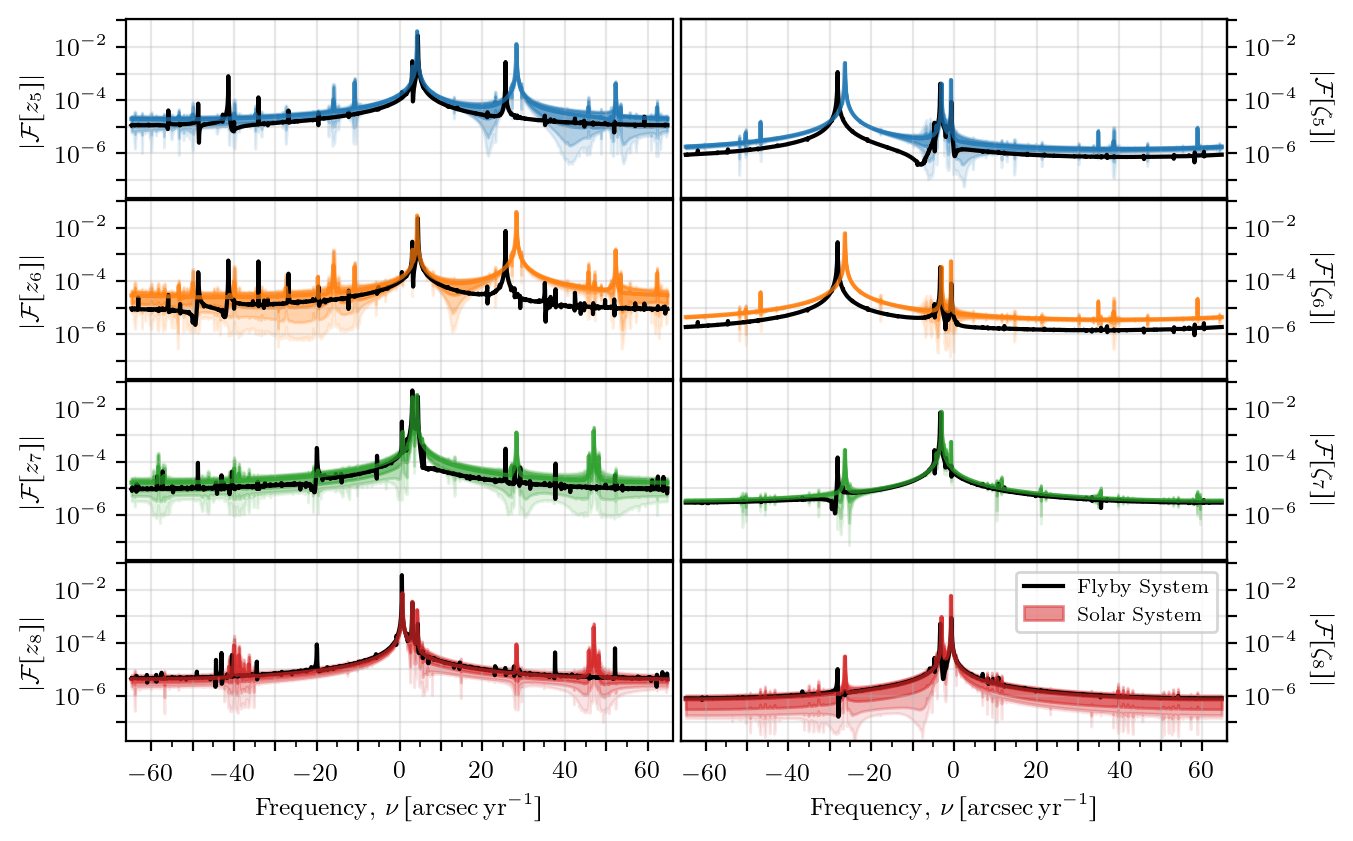

In [33]:
fftplot(results[inds[0]], pp, savename="figures/best-fft-oja.pdf",)

### Flyby Perihelion

In [34]:
# Recreate the flyby event to generate figure at perihelion.
index = int(inds[0])
sim = pal.unpkl("data/initial_conditions.sims")[index]
airball.add_star_to_sim(sim, stars[index], "star")
tperi = sim.particles["star"].T - sim.t
sim.integrate(sim.t + tperi)

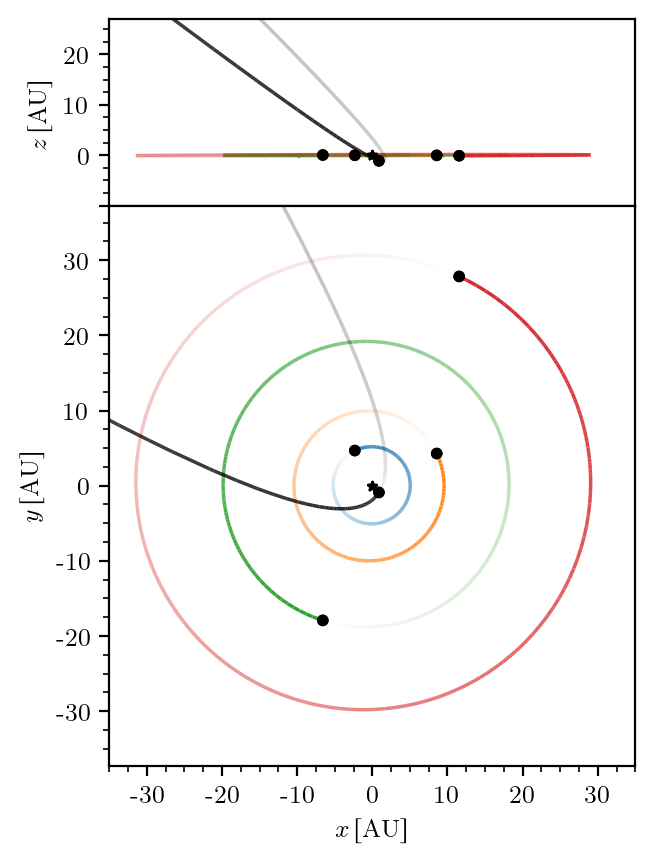

In [35]:
plt.rcParams.update({"font.size": 9})
fakefig, fake = plt.subplots(1, 1)
fig, ax = plt.subplots(
    2,
    1,
    figsize=(col_width, col_width * 1.42857143),
    gridspec_kw=dict(height_ratios=[1, 3], hspace=0),
    sharex=True,
)

mx = 35
op = rebound.OrbitPlotSet(
    sim,
    color=[
        (31 / 255, 119 / 255, 180 / 255),
        (255 / 255, 127 / 255, 14 / 255),
        (44 / 255, 160 / 255, 44 / 255),
        (214 / 255, 39 / 255, 40 / 255),
        "black",
    ],
    xlim=[-mx, mx],
    ylim=[-mx, mx],
    fig=fig,
    ax=[ax[1], ax[0], fake],
    unitlabel=r"$\mathrm{[AU]}$",
    Narc=256,
    lw=1.25,
)
for attr in ["main", "top", "right"]:
    getattr(op, attr).particles.set_sizes([10] * 5)
    getattr(op, attr).primary.set_sizes([10])
plt.close(fakefig)

ax[1].set_xticks([], [])
ax[1].set_yticks(np.linspace(-40, 40, 33), [""] * 33, minor=True)
ax[1].set_yticks(
    np.linspace(-30, 30, 7),
    [r"-$30$", r"-$20$", r"-$10$", r"$0$", r"$10$", r"$20$", r"$30$"],
)
ax[0].set_xticks(np.linspace(-40, 40, 33), [""] * 33, minor=True)
ax[0].set_xticks(
    np.linspace(-30, 30, 7),
    [r"-$30$", r"-$20$", r"-$10$", r"$0$", r"$10$", r"$20$", r"$30$"],
)
ax[0].set_yticks(np.linspace(-10, 27.5, 16), [""] * 16, minor=True)
ax[0].set_yticks(np.linspace(-10, 20, 4), [r"", r"$0$", r"$10$", r"$20$"])

ax[1].axis("equal")
ax[1].set_xlim(-mx, mx)
ax[0].set_xlim(-mx, mx)
ax[0].set_ylim(-10, 27)
ax[1].set_ylabel(r"$y\,\mathrm{[AU]}$")
ax[0].set_ylabel(r"$z\,\mathrm{[AU]}$")
ax[1].set_xlabel(r"$x\,\mathrm{[AU]}$")

plt.savefig("figures/orbit-plot-oja.pdf", bbox_inches="tight")
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
try:
    sa = rebound.Simulationarchive("data/flyby_19399_details.sa")
except FileNotFoundError:
    sim = pal.unpkl("data/initial_conditions.sa")[index]
    star = airball.Stars("data/flyby.stars")[index]
    sim.save_to_file(
        "data/flyby_19399_details.sa", interval=1e3 * twopi, delete_file=True
    )
    airball.flyby(sim, star)
    sim.integrate(2.5e6 * twopi)
    sa = rebound.Simulationarchive("data/flyby_19399_details.sa")

In [37]:
s = sa[-1]
s.synchronize()
try:
    s.remove(hash="flybystar")
except RuntimeError:
    pass
inv_plane = s.angular_momentum()
rotation = rebound.Rotation.to_new_axes(newz=inv_plane)

N = len(sa)
t = np.zeros(N)
r = np.zeros(N)
a = np.zeros((N, 4))
e = np.zeros((N, 4))
inc = np.zeros((N, 4))
for i in range(N):
    s = sa[i]
    s.synchronize()
    try:
        s.remove(hash="flybystar")
    except RuntimeError:
        pass
    s.rotate(rotation)
    t[i] = s.t / twopi
    o = s.orbits()
    for j in range(4):
        a[i, j] = o[j].a
        e[i, j] = o[j].e
        inc[i, j] = o[j].inc

/Users/zyrxvo/Documents/Research/Project Dawn/open-cluster/project-dawn/Secular-Origin/.venv/lib/python3.11/site-packages/rebound/simulationarchive.py:150: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)


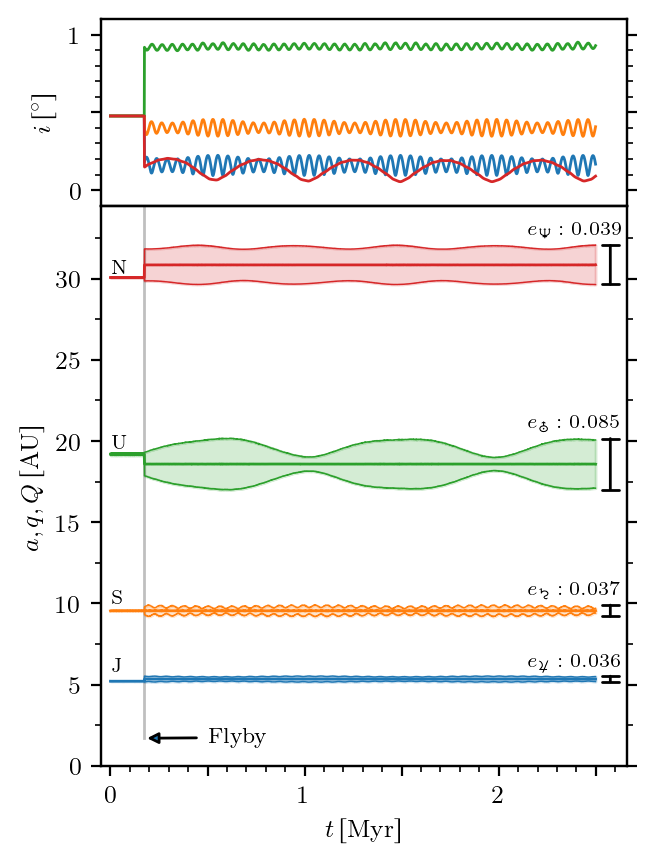

In [38]:
names = [r"\Jupiter", r"\Saturn", r"\Uranus", r"\Neptune"]
name = [r"$\mathrm{J}$", r"$\mathrm{S}$", r"$\mathrm{U}$", r"$\mathrm{N}$"]
plt.rcParams.update({"font.size": 9})
fig, ax = plt.subplots(
    2,
    1,
    figsize=(col_width, col_width * 1.42857143),
    gridspec_kw=dict(height_ratios=[1, 3], hspace=0),
    sharex=True,
)

ax[1].plot(
    [tperi / twopi, tperi / twopi],
    [100, airball.Stars("data/flyby.stars")[index].q(ss).value],
    "k",
    lw=1,
    alpha=0.25,
)
ax[1].annotate(
    r"$\mathrm{Flyby}$",
    xy=(1.6e5, 1.69),
    xytext=(5e5, 1.39),
    arrowprops=dict(arrowstyle="-|>"),
    size=8,
)
for j in range(4):
    ax[0].plot(t, inc[:, j] * u.rad.to(u.deg), f"C{j}-", lw=1)
    ax[1].plot(t, a[:, j], f"C{j}-", lw=1)
    ax[1].plot(t, a[:, j] * (1 - e[:, j]), f"C{j}-", lw=0.5)
    ax[1].plot(t, a[:, j] * (1 + e[:, j]), f"C{j}-", lw=0.5)
    ax[1].fill_between(
        t, a[:, j] * (1 - e[:, j]), a[:, j] * (1 + e[:, j]), color=f"C{j}", alpha=0.2
    )
    cut = t > 0  # tperi
    ax[1].annotate(
        "",
        xy=(2.575e6, a[-1, j] * (1 - np.max(e[cut, j])) - 0.33),
        xytext=(2.575e6, a[-1, j] * (1 + np.max(e[cut, j])) + 0.33),
        arrowprops=dict(arrowstyle="|-|"),
        size=3,
    )
    ax[1].text(
        2.15e6,
        a[-1, j] * (1 + np.max(e[cut, j])) + 0.6,
        rf"$e_{names[j]}:{np.max(e[cut, j]):5.3f}$",
        fontdict={"size": 7},
    )
    ax[1].text(1e4, a[0, j] + 0.6 - j * 0.1, name[j], fontdict={"size": 7})


ay = [None, None]
ax[0].set_yticks(np.linspace(0, 1, 11), minor=True)
ax[0].set_yticks(np.linspace(0, 1, 3), [r"$0$", r"", r"$1$"])
ax[0].set_ylabel(r"$i\,\mathrm{[{}^{\circ}]}$")

ay[0] = ax[0].twinx()
ay[0].set_yticks(np.linspace(0, 1, 11), [""] * 11, minor=True)
ay[0].set_yticks(np.linspace(0, 1, 3), [""] * 3)

ax[1].set_xlabel(r"$t\,\mathrm{[Myr]}$")
ax[1].set_xticks(np.linspace(0, 5.5e6, 56), [""] * 56, minor=True)
ax[1].set_xticks(
    np.linspace(0, 5e6, 11),
    [r"$0$", "", r"$1$", "", r"$2$", "", r"$3$", "", r"$4$", "", r"$5$"],
)

ax[1].set_yticks(np.linspace(0, 35, 15), [""] * 15, minor=True)
ax[1].set_yticks(
    np.linspace(0, 35, 8),
    [r"$0$", r"$5$", r"$10$", r"$15$", r"$20$", r"$25$", r"$30$", ""],
)
ax[1].set_ylabel(r"$a,q,Q\,\mathrm{[AU]}$")

ay[1] = ax[1].twinx()
ay[1].set_yticks(np.linspace(0, 35, 15), [""] * 15, minor=True)
ay[1].set_yticks(np.linspace(0, 35, 8), [""] * 8)


ax[0].set_ylim(-0.1, 1.1)
ay[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(0, 34.5)
ay[1].set_ylim(0, 34.5)
ax[1].set_xlim(-5e4, 2.66e6)

plt.savefig("figures/flyby-effect-oja.pdf", bbox_inches="tight")
plt.show()

## Metric Comparisons

### Nice Criteria

In [39]:
A = [False] * len(results)  # 4 planets
B = (
    [False] * len(results)
)  # Semi-major axes are within 20%, final mean eccentricities and mean inclinations are no larger than 0.11 and 2°, respectively
C = [False] * len(results)  # e_55 > 0.022
for i in range(len(results)):
    A[i] = results[i].good
    if A[i]:
        B[i] = np.all(np.abs((results[i].a - ss_outer.a) / ss_outer.a) < 0.2)
        B[i] = B[i] and np.all(np.mean(np.abs(results[i].z), axis=0) < 0.11)
        B[i] = B[i] and np.all(
            np.mean(2 * np.arcsin(np.abs(results[i].ζ)), axis=0) * u.rad.to(u.deg) < 2
        )
        if B[i]:
            C[i] = np.sqrt(np.sum(np.abs(results[i].Sg) ** 2, axis=1))[0] > 0.022
            # C[i] = np.abs(results[i].A[0]) > 0.022
A = np.asarray(A)
B = np.asarray(B)
C = np.asarray(C)

In [40]:
nice_ABC = np.round(
    100 * np.array([np.sum(A) / stars.N, np.sum(B) / stars.N, np.sum(C) / stars.N]), 1
)
print(
    f"Percent of simulations that satisfy criteria A: {nice_ABC[0]}%, A & B: {nice_ABC[1]}%, and A & B & C: {nice_ABC[2]}%"
)

Percent of simulations that satisfy criteria A: 41.3%, A & B: 19.3%, and A & B & C: 2.3%


In [41]:
print(
    f"Num LSD matches: {np.sum(matches)}\nLSD & A: \t {np.sum(np.logical_and(matches, A))}\nLSD & A & B: \t {np.sum(np.logical_and(matches, B))}\nLSD & A & B & C: {np.sum(np.logical_and(matches, C))}"
)

Num LSD matches: 422
LSD & A: 	 422
LSD & A & B: 	 329
LSD & A & B & C: 180


### Keplerian Elements

In [42]:
def load_kepler_elements(reb_sims):
    """Returns the Keplerian elements a,e,i from a list of REBOUND simulations."""
    n = len(reb_sims)
    aei = np.zeros((n, 3, 4))
    for i in range(n):
        s = reb_sims[i]
        s.synchronize()
        airball.tools.rotate_into_plane(s)
        o = s.orbits(primary=s.particles[0])
        for j in range(4):
            aei[i, 0, j] = o[j].a
            aei[i, 1, j] = o[j].e
            aei[i, 2, j] = o[j].inc
    return aei

In [43]:
post_flyby = pal.unpkl("data/post_flyby_conditions.sims")
kep = load_kepler_elements(post_flyby)

In [44]:
def kepler_metric(flyby, solarsystem, weights=[0.01, 0.1, 0.1], se_si_override=None):
    a, e, i = flyby[0], flyby[1], flyby[2]
    sa, se, si = solarsystem[0], solarsystem[1], solarsystem[2]
    se_d, si_d = se, si
    if se_si_override is not None:
        se_d, si_d = se_si_override
    total = (
        ((a - sa) / (weights[0] * sa)) ** 2
        + ((e - se) / (weights[1] * se_d)) ** 2
        + ((i - si) / (weights[2] * si_d)) ** 2
    )
    return total.sum()

In [45]:
kepmet = np.asarray(
    [
        kepler_metric(
            kep[i],
            (ss_outer.a, ss_outer.e, ss_outer.inc),
            weights=[0.1, 1, 1],
        )
        for i in range(len(kep))
    ]
)

In [46]:
mean_flyby_metric = np.mean(flyby_metric, axis=1)

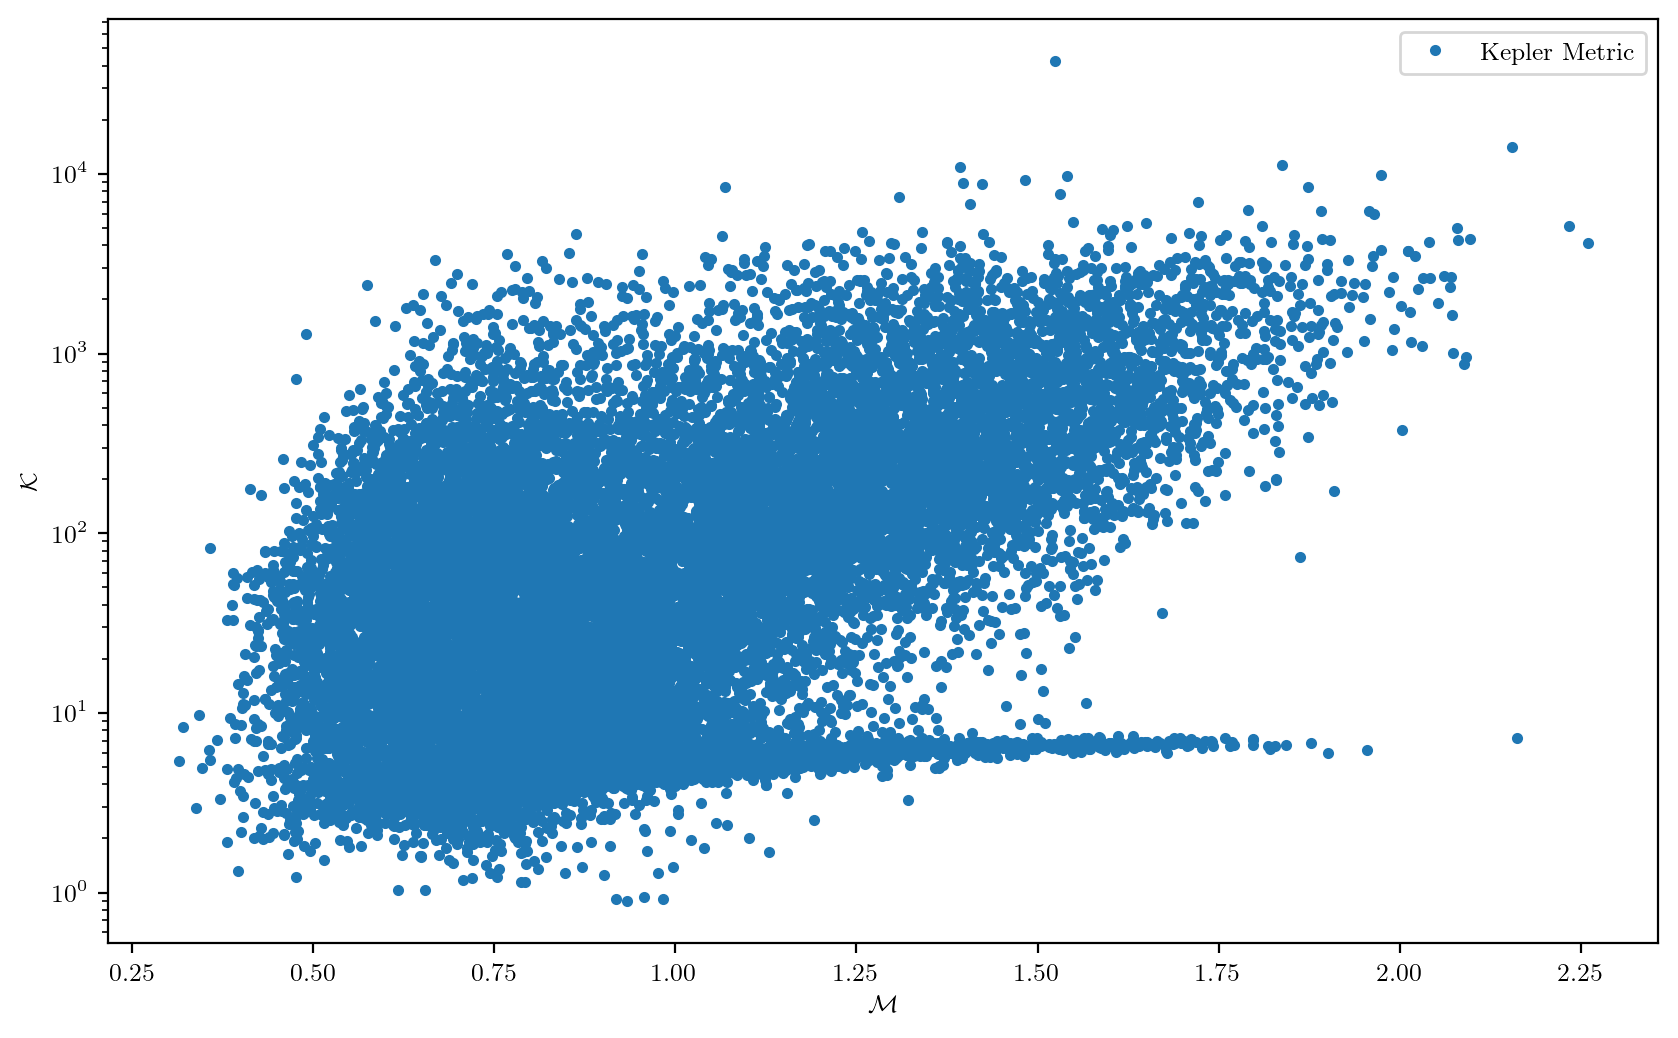

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=False, sharey=False)
ax.plot(mean_flyby_metric, kepmet, ".", label=r"Kepler Metric")
ax.legend()
ax.set_xlabel(r"$\mathcal{M}$")
ax.set_ylabel(r"$\mathcal{K}$")
ax.set_yscale("log")
plt.show()

In [48]:
kepbest = np.argmin(kepmet)
print(f"Best flyby system according to the Kepler Metric: {kepbest}")

Best flyby system according to the Kepler Metric: 46076


46076, M: ( 0.85326,  0.93048,  1.09215)
<airball.stars.Star object at 0x13fb73790, m= 1.67 jupiterMass, b= 38.62 AU, v= 2.395 km / s, inc= 52.16 deg, omega= 338.6 deg, Omega= 9.022 deg>
q: 4.733464410968486 AU
ss   5.2025,   9.5460,  19.1945,  30.0704
->   5.1800,   9.5103,  19.0316,  29.8663

ss   4.2575,  28.2458,   3.0880,   0.6730
->   4.2167,   4.2169,   4.2170,   0.7026
ss 44.172792, 48.205320, 29.027593, 9.137972
-> 34.664002, 24.379187, 38.839795, 9.221603

ss  -0.6917, -26.3483,  -2.9926,  -0.6918
->  -0.7055, -26.0640,  -3.0867,  -0.7082
ss 0.577392, 7.848114, 8.869732, 5.811626
-> 0.378769, 4.769235, 3.282498, 5.099654



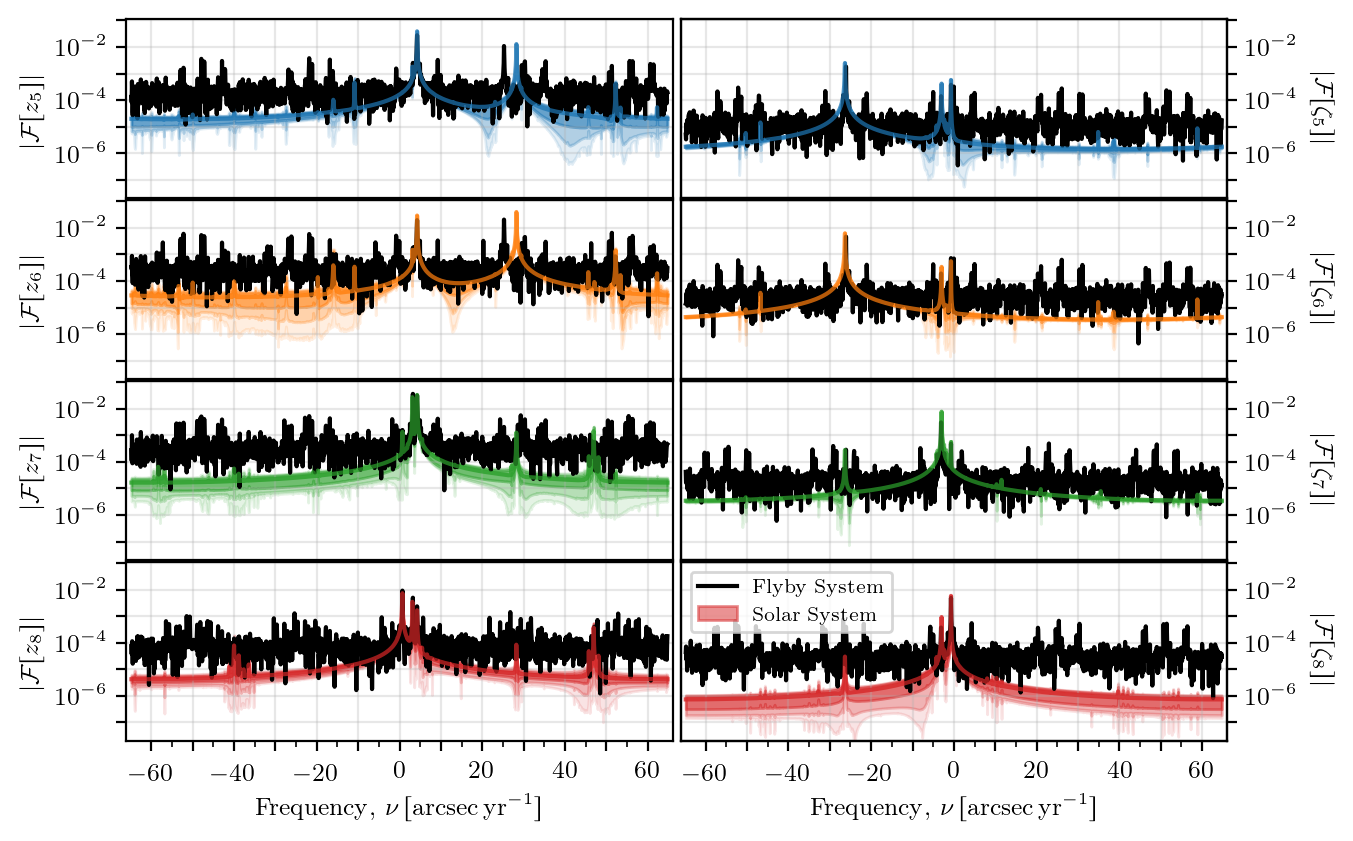

In [49]:
fftplot(results[kepbest], pp)

### AMD

In [50]:
try:
    amd = np.load("data/flybys_amd.npy")
except FileNotFoundError:
    amd = np.zeros(stars.N)
    for i in range(stars.N):
        s = pal.unpkl("post_20Myr_flyby_conditions.sims")
        s.synchronize()
        n, d = pal.secular.nAMD(s)
        amd[i] = np.sum(n) / np.sum(d)
    np.save("data/flybys_amd.npy", amd)

In [51]:
n, d = pal.secular.nAMD(ss)
C0 = np.sum(n) / np.sum(d)

In [52]:
inds2 = np.arange(stars.N)[np.logical_and(matches, C0)]
inds2 = inds2[
    np.argsort(np.sum(flyby_metric[inds2] < solar_system_metric.max(), axis=1))[::-1]
]

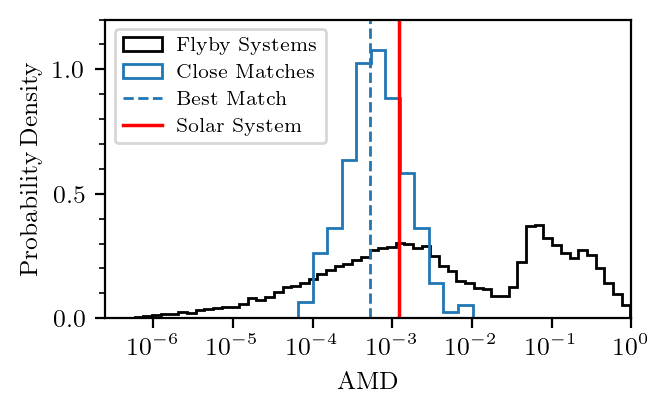

In [53]:
plt.rcParams.update({"font.size": 9})
fig, ax = plt.subplots(
    1, 1, figsize=(col_width, col_width * 0.57142857), sharex=False, sharey=False
)
ax.hist(
    np.log10(amd),
    bins=60,
    color="k",
    density=True,
    histtype="step",
    lw=1,
    label=r"Flyby Systems",
)
ax.hist(
    np.log10(amd[inds]),
    bins=12,
    color="C0",
    density=True,
    histtype="step",
    lw=1,
    label=r"Close Matches",
)
# ax.hist(np.log10(amd[inds2]), bins=12, color='g', density=True, histtype='step', lw=1, label=r'Nice Matches');
ax.axvline(np.log10(amd[inds[0]]), c="C0", ls="--", lw=1, label=r"Best Match")
ax.axvline(np.log10(C0), c="r", lw=1.25, label=r"Solar System")
ax.legend(loc=2, prop={"size": 7})
ax.set_xlabel(r"$\mathrm{AMD}$")
ax.set_ylabel(r"$\mathrm{Probability\,Density}$")
ax.set_xticks(
    np.linspace(-7, 0, 8), [rf"$10^{{{i:1.0f}}}$" for i in np.linspace(-7, 0, 8)]
)
ax.set_yticks(np.linspace(0, 1.2, 13), minor=True)
ax.set_yticks(np.linspace(0, 1, 3))
ax.set_xlim(-6.6, 0)
plt.savefig("figures/amd-oja.pdf", bbox_inches="tight")
plt.show()